## Noise analysis
In this notebook the weight and airflow data of an exemplatory batch are analysized for their noise levels. The goal is to extract a typical standard deviation for each data type to apply for synthetic data sets.

<hr>
Summary:
Airflow noise can be directly analysed from a steady period. Weight noise is best analysed after differencing and trimming (0.05 and 0.95 percentile).
<hr>


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# read csv file
noise_data = pd.read_csv('Noise_data.csv')

In [3]:
print_figures = False

# set matplotlib settings
if print_figures:
    plt.rcParams['figure.dpi'] = 300  # High resolution for saving
    plt.rcParams['font.size'] = 14
    plt.rcParams['axes.labelsize'] = 16
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['legend.fontsize'] = 12
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14

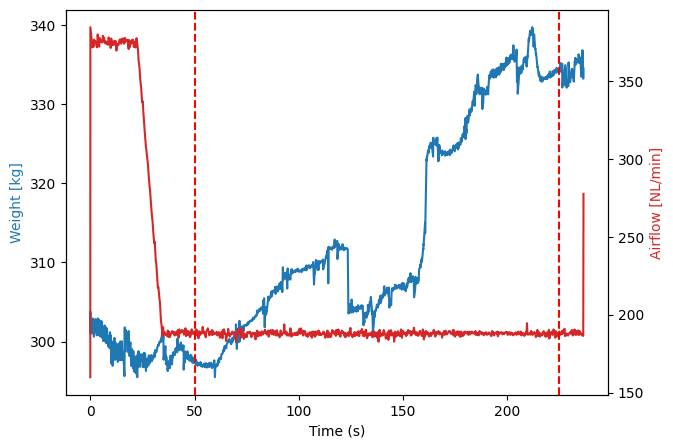

In [4]:
# plot both weight and airflow data
fig, ax1 = plt.subplots()
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Weight [kg]', color='tab:blue')
ax1.plot(noise_data['weight_t'], noise_data['weight_value'], color='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Airflow [NL/min]', color='tab:red')
ax2.plot(noise_data['airflow_t'], noise_data['airflow_value'], color='tab:red')

# Adding vertical red dotted lines
for x in [50, 225]:
    plt.axvline(x=x, color='red', linestyle='--')

#fig.set_dpi(300)
fig.set_size_inches(7,5)


plt.show()


### Airflow noise analysis

In [5]:
# airflow_value noise will be analysed between 50 and 225 h, since the setpoint is not changed here
airflow_sample = noise_data[(noise_data['airflow_t'] >= 50) & (noise_data['airflow_t'] <= 225)][['airflow_t', 'airflow_value']]


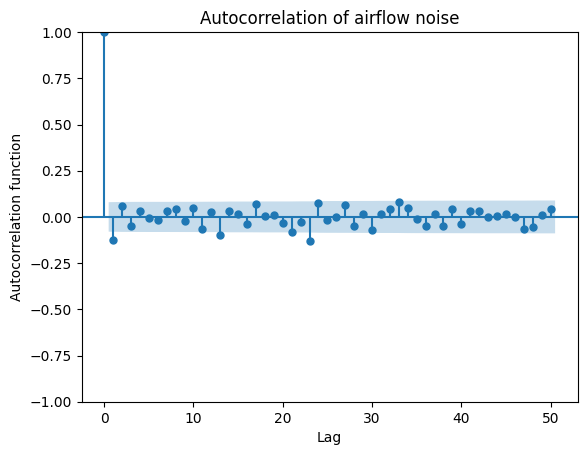

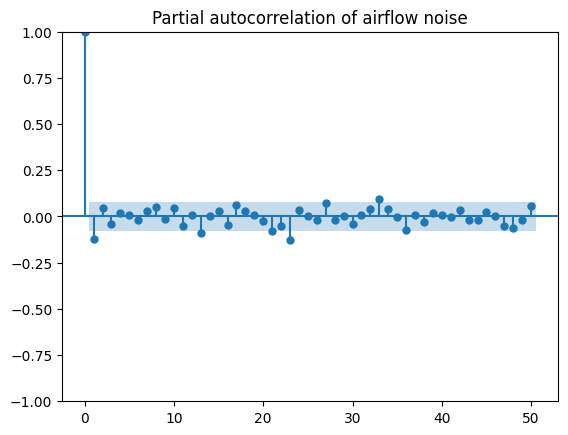

Standard deviation of airflow noise: 1.42 [NL/min]


In [6]:
# autocorrelation of airflow
acf = plot_acf(airflow_sample['airflow_value'], lags=50)  # Adjust 'lags' based on the length of your data
if print_figures:
    acf.get_figure().gca().set_title("") # no title for printing
else:
    plt.title('Autocorrelation of airflow noise')
plt.ylabel('Autocorrelation function')
plt.xlabel('Lag')
plt.show()

# partial autocorrelation of airflow
plot_pacf(airflow_sample['airflow_value'], lags=50)  # Adjust 'lags' based on the length of your data
plt.title('Partial autocorrelation of airflow noise')
# set y label

plt.show()

airflow_std = airflow_sample['airflow_value'].std()
print(f"Standard deviation of airflow noise: {airflow_std:.2f} [NL/min]")

### Weight noise analysis

Standard deviation of weight noise: 1.02 [kg]


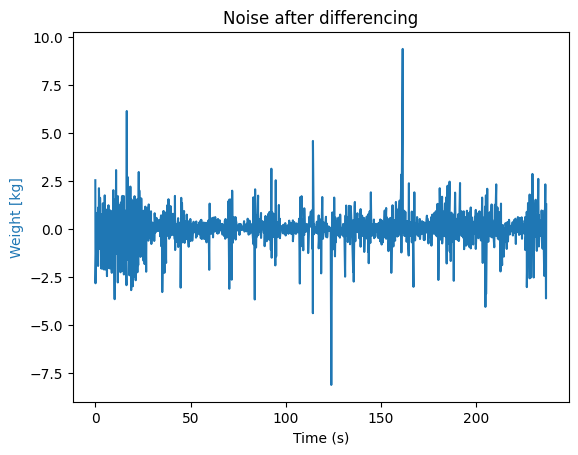

In [7]:
from scipy.signal import medfilt
# weight noise sample
weight_sample = pd.DataFrame(noise_data, columns=['weight_t', 'weight_value'])
# differencing
weight_sample['weight_value'] = weight_sample['weight_value'].diff()
# median filter
#weight_sample['weight_value'] = medfilt(weight_sample['weight_value'], kernel_size=5)

# plot residual data
fig, ax1 = plt.subplots()
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Weight [kg]', color='tab:blue')
ax1.plot(weight_sample['weight_t'], weight_sample['weight_value'], color='tab:blue')
if print_figures:
    ax1.title.set_text('')
else:
    ax1.title.set_text('Noise after differencing')

# Standard deviation
weight_std = weight_sample['weight_value'].std()
print(f"Standard deviation of weight noise: {weight_std:.2f} [kg]")


Standard deviation of weight noise: 0.76 [kg]


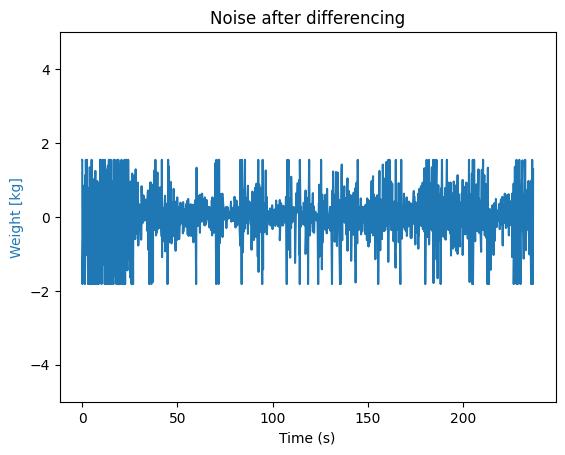

In [8]:
# Apply winsoring to the weight noise
from scipy.stats.mstats import winsorize
weight_sample_winsor = weight_sample.copy()
weight_sample_winsor['weight_value'] = winsorize(weight_sample_winsor['weight_value'], limits=[0.05, 0.05])

# plot residual data
fig, ax1 = plt.subplots()
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Weight [kg]', color='tab:blue')
ax1.plot(weight_sample_winsor['weight_t'], weight_sample_winsor['weight_value'], color='tab:blue')
ax1.title.set_text('Noise after differencing')
ax1.set_ylim([-5, 5])

# Standard deviation
weight_std = weight_sample_winsor['weight_value'].std()
print(f"Standard deviation of weight noise: {weight_std:.2f} [kg]")

Standard deviation of weight noise after trimming: 0.57 [kg]


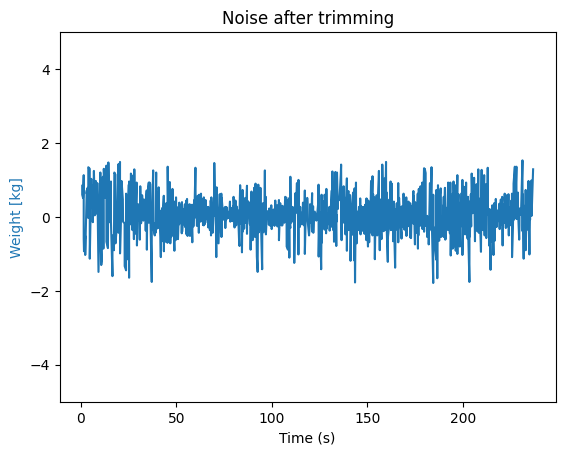

In [9]:
# Trimming spikes
# Determine the 5th and 95th percentiles of the 'value' column
lower_percentile = weight_sample['weight_value'].quantile(0.05)
upper_percentile = weight_sample['weight_value'].quantile(0.95)

# Trim values outside the 5th and 95th percentiles from the 'value' column
weight_sample_trim = weight_sample[(weight_sample['weight_value'] > lower_percentile) & (weight_sample['weight_value'] < upper_percentile)]

# plot residual data
fig, ax1 = plt.subplots()
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Weight [kg]', color='tab:blue')
ax1.plot(weight_sample_trim['weight_t'], weight_sample_trim['weight_value'], color='tab:blue')
if print_figures:
    ax1.title.set_text('')
else:
    ax1.title.set_text('Noise after trimming')
ax1.set_ylim([-5, 5])

# Standard deviation
weight_std = weight_sample_trim['weight_value'].std()
print(f"Standard deviation of weight noise after trimming: {weight_std:.2f} [kg]")

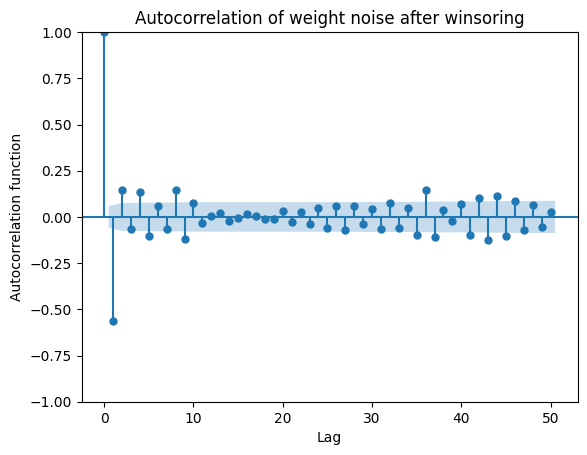

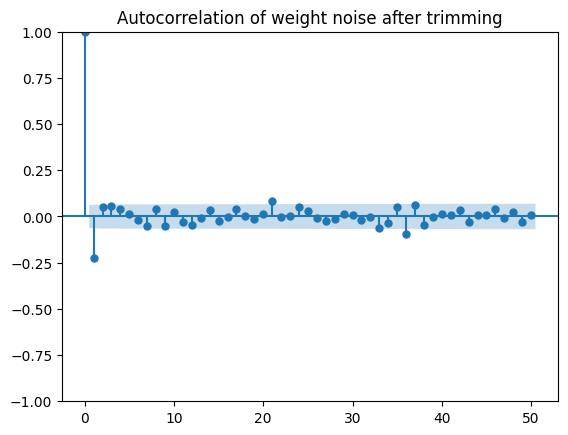

In [10]:
# ACF of weight noise after differencing and winsoring
acf_weight = plot_acf(weight_sample_winsor['weight_value'], lags=50)  # Adjust 'lags' based on the length of your data
if print_figures:
    acf_weight.get_figure().gca().set_title("") # no title for printing
else:
    plt.title('Autocorrelation of weight noise after winsoring')
plt.ylabel('Autocorrelation function')
plt.xlabel('Lag')
plt.show()

# ACF of weight noise after differencing and trimming
plot_acf(weight_sample_trim['weight_value'], lags=50)  # Adjust 'lags' based on the length of your data
plt.title('Autocorrelation of weight noise after trimming')
plt.show()